##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

في هذا الدرس سوف نقوم بشرح كيفية تصنيف القطط و الكلاب من الصور, سوف نقوم ببناء النموذج باستخدام `tf.keras.Sequential`
 `tf.keras.preprocessing.image.ImageDataGenerator`و سوف نقوم بتحميل الصور باستخدام 
 في هذا الدرس سوف تكسب بعض المهارات العملية لهذه المبادئ:
 
 *  `tf.keras.preprocessing.image.ImageDataGenerator` التعامل مع البيانات و الصور باستخدام 
 * التعرف علي مصطلح الoverfitting و التعرف علي كيفية منعها 
 * كيفية جمع البيانات و زيادة البيانات و مصطلح الdropout وهما طرق لمحاربة الoverfitting في مهام رؤية الحاسوب 
 
في هذا الدرس سنقوم بتتبع سير العمل الطبيعي في مهام تعلم الآلة:



1. فحص وفهم البيانات
2. بناء و تحضير المدخلات
3. بناء النموذج
4. تدريب النموذج
5. تقييم النموذج
6. تحسين النموذج وتكرار الخطوات 

## تضمين المكتبات التي سوف نحتاجها

سنبدأ بتضمين المكتبات المطلوبة.
`os` و يتم استخدامها لقراءة الملفات 
NumPy يتم استخدامها للتعامل مع المصفوفات و القيام بعمليات المصفوفات عليهم 
`matplotlib.pyplot` لعرض الصور و رسم علاقات بين المتغيرات أثناء التدريب والتقييم

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

نقوم بتضمين Tensorflow و Keras لكي نستطيع بناء النموذج

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## نقوم بتحميل البيانات

 
 نبدأ بتحميل مجموعة البيانات, في  هذا الدرس يتم استخدام نسخة منتقية من 
<a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a>
 هذه المجموعة من Kaggle 
يمكنك تحميلها و وضعها في "/tmp/" directory.

In [1]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

NameError: name 'tf' is not defined

تتكون مجموعة الصور من هذه الهيكلة
<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

بعد استخراج المحتويات 
نضع المسار للصور المستخدمة في التدريب و المسار للصور المستخدمة في التقييم في متغيرات

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### فهم البيانات

لنبدأ ننظر لعدد صور القطط وعدد صور الكلاب في مجموعة الصور

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


للتسهيل, نضع بعض المتغيرات التي سيتم استخدامها في التدريب

In [10]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## تجهيز البيانات

تجهيز الصور قبل إدخالها الشبكة العصبية عن طريق:

1. قراءة الصور من القرص.
2. تحويل الصور إلي مصفوفات ثلاثية الأبعاد تتكون من 3 قنوان ألوان ( أحمر - أخضر - أزرق ).
3. ﻷن الشبكة العصبية تفضل التعامل مع الأرقام الصغيرة نقوم بتحويل قيم المصفوفات التي تكون في مدي 0-255 إلي مدي 0-1 

 `ImageDataGenerator` لحسن الحظ يمكن تنفيذ كل هذه المهام باستخدام 
يمكنها قراءة الصور و تحويلها للشكل المطلوب الذي يسهل التعامل معه

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

`flow_from_directory` تقوم بقراءة الصور من القرص و تحويل القيم بداخل المصفوفة إلي قيم بين 0 و 1 و تحويلها لشكل المصفوفة المطلوب

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### عرض الصور التي سيتم التدرب عليها

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [14]:
sample_training_images, _ = next(train_data_gen)

 `next` تقوم بإرجاع جزء من مجموعة الصور. 
 و القيمة التي تعود تكون علي الشكل`(x_train, y_train)` 
x_train هو مجموعة الصور التي سيتم التدرب عليها
y_train هو اسم القسم الذي تنتمي إليه الصورة سواء كان قطة أو كلب

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

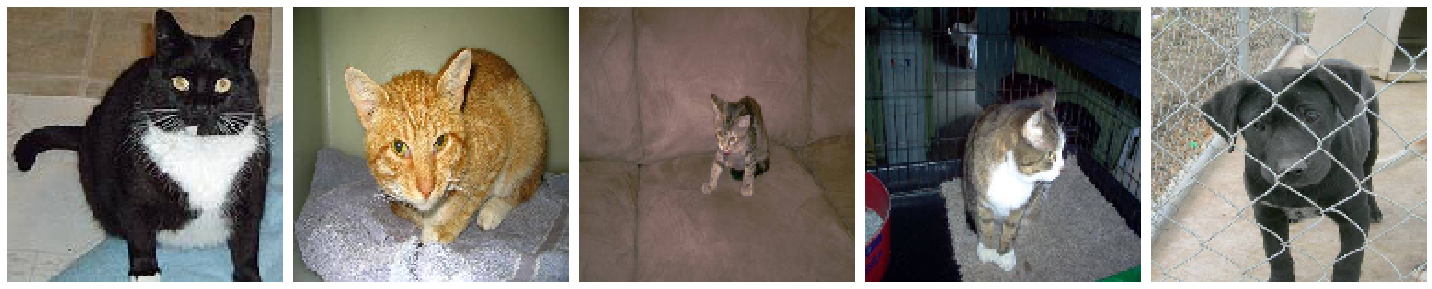

In [16]:
plotImages(sample_training_images[:5])

## بناء النموذج

النموذج يتكون من 3 طبقات من الconvolutions
و بعد كل طبقة يوجد طبقة من ال max pool 
و بعدهم يوجد طبقة متصلة بالكامل تتكون من 512 وحدة مع دالة تفعيل `relu`

In [17]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### تدريب النموذج

في هذا النموذج سوف نستخدم *ADAM*لتدريب النموذج
و سوف يتم استخدام *binary cross entropy* لتقييم المخرجات من النموذج. 
لنري الدقة في التدريب والتقيم أثناء التدريب نقوم بتمرير `accuracy` إلي المعطي `metrics`

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### موجز النموذج

سنري كل الطبقات في الشبكة لهذا النموذج باستخدام دالة  `summary`

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### تدريب النموذج

باستخدام`fit_generator`  التي متضمنة في `ImageDataGenerator` نقوم بالتدريب.

In [20]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 8s 542ms/step - loss: 0.9712 - accuracy: 0.5027 - val_loss: 0.6865 - val_accuracy: 0.5089
Epoch 2/15
15/15 [==============================] - 8s 507ms/step - loss: 0.6757 - accuracy: 0.5369 - val_loss: 0.6614 - val_accuracy: 0.6239
Epoch 3/15
15/15 [==============================] - 8s 509ms/step - loss: 0.6264 - accuracy: 0.6122 - val_loss: 0.6173 - val_accuracy: 0.6060
Epoch 4/15
15/15 [==============================] - 8s 511ms/step - loss: 0.5795 - accuracy: 0.6597 - val_loss: 0.5979 - val_accuracy: 0.6562
Epoch 5/15
15/15 [==============================] - 7s 497ms/step - loss: 0.5386 - accuracy: 0.7062 - val_loss: 0.5890 - val_accuracy: 0.6942
Epoch 6/15
15/15 [==============================] - 8s 512ms/step - loss: 0.4891 - accuracy: 0.7505 - val_loss: 0.5731 - va

### إظهار نتائج التدريب

الأن سنري النتائج بعد تدريب النموذج

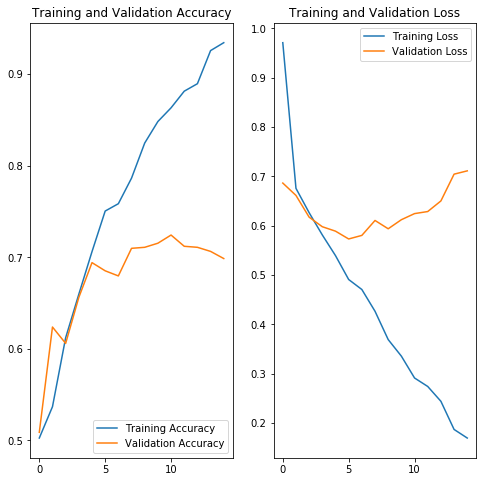

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

كما تري في هذه الرسوم 
فيوجد فاصل بين كفاءة النموذج في التدريب و كفائته في التقييم كما إنه حصل علي كفاءة 70% فقط في التقييم

لنري ماذا حدث خطأ و نحاول تحسين الأداء

## Overfitting

في الرسوم فوق, يظهر أن كفاءة النموذج أثناء التدريب في ازدياد مع الوقت بينما كفاءة النموذج أثناء تقييمه تقريبا ثابتة عند 70% و ذلك يبدو علامة علي الoverfitting 

عندما يكون هناك عدد قليل من الأمثلة التي يتم التدرب عليها. يمكن للنموذج أن يتعلم بعض الخصائص الغير مرغوب في تعلمها و يتعلم بعض الصفات الغير مميزة للمطلوب تعلمه و هذا يقلل من أداؤه عندما يري أمثلة جديدة لم يرها من قبل و يجد صعوبة في تعميم الصفات و الخصائص التي تعلمها لأنه تعلم أشياء غير مرغوبة وتسمي هذه الظاهرة بالoverfitting

يوجد طرق عديدة لتجنب هذه الطاهرة و في هذا الدرس سوف نتعلم عن بعض الطرق و منهم data augmentation و dropout

## Data augmentation

يتم استخدام هذا المبدأ لتجنب الظاهرة التي تم وصفها سابقا
و هذا المبدأ يعتمد بشكل أساسي علي زيادة عدد الأمئلة التي يتم التدرب عليها عن طريق زيادة الأمثلة باختلاق أكثر من مثال مختلف عن طريق مثال واحد علي سبيل المثال تغيير الألوان و الإضاءة في صورة أو تدوير و قلب الصور

و يتم فعل ذلك باستخدام `tf.keras` باستخدام `ImageDataGenerator`
و بإعطاءه بعض  التحويلات المراد تطبيقها علي الصور أثناء التدريب


### تجميع و إظهار الصور

نبدأ بتطبيق تقليب أفقي عشوائي للصور و نري كيف تتغير الصور بعد التغير

### تطبيق تقليب أفقي

نمرر `horizontal_flip` كمعطي ل `ImageDataGenerator` و نضع `True` للتطبيق

In [22]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [23]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


نأخذ صورة كعينة من الأمثلة و نكررها 5 مرات فيتم القيام بتحويل الصورة 5 مرات

In [24]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

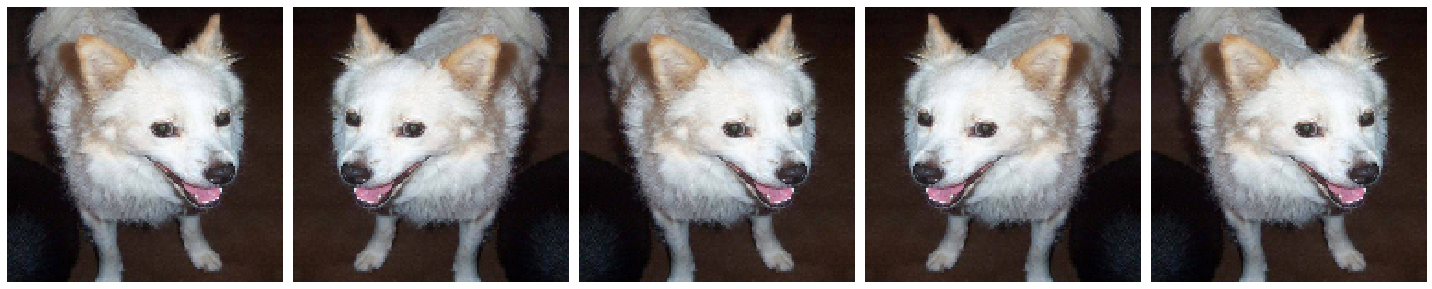

In [25]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### تدوير الصورة عشوائيا

لنري طرق أخري لتجميع الصور و زيادة عدد الأمثلة وهي تدوير الصور عشوائيا 45 درجة

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


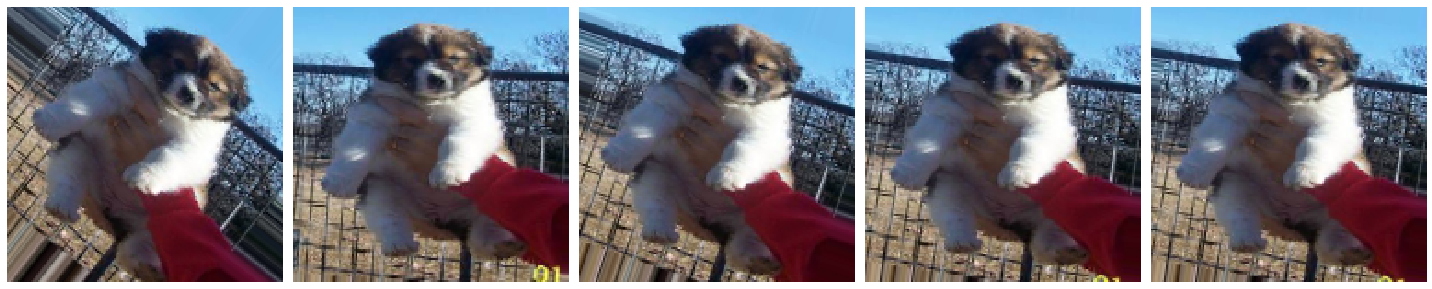

In [28]:
plotImages(augmented_images)

### Apply zoom augmentation


نقوم بتجميع الصورة وزيادة عددهم عن طريق تكبير الصورة

In [29]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [30]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


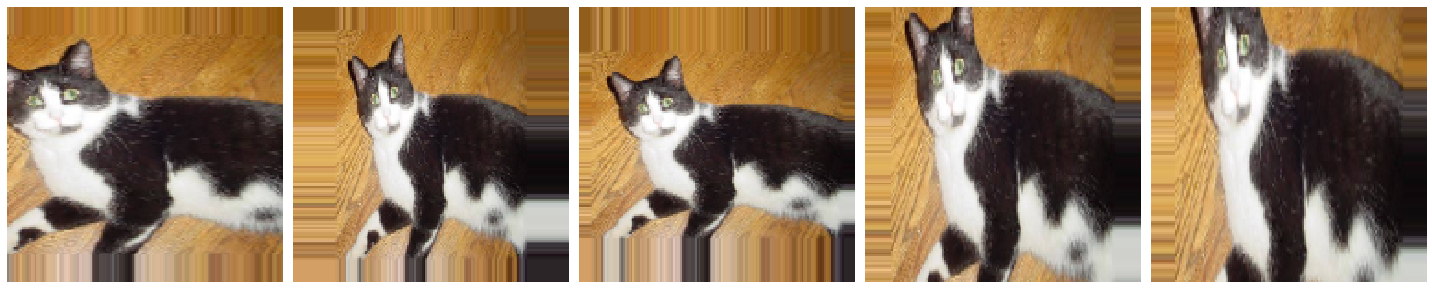

In [31]:
plotImages(augmented_images)

### وضع كل ذلك سويا

بتطبيق جميع الطرق السابقة لزيادة عدد الأمثلة 

In [32]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [33]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.



توضيح كيف صورة واحدة تظهر مختلفة 5مرات عندما نقوم بتطبيق طرق زيادة الصور 

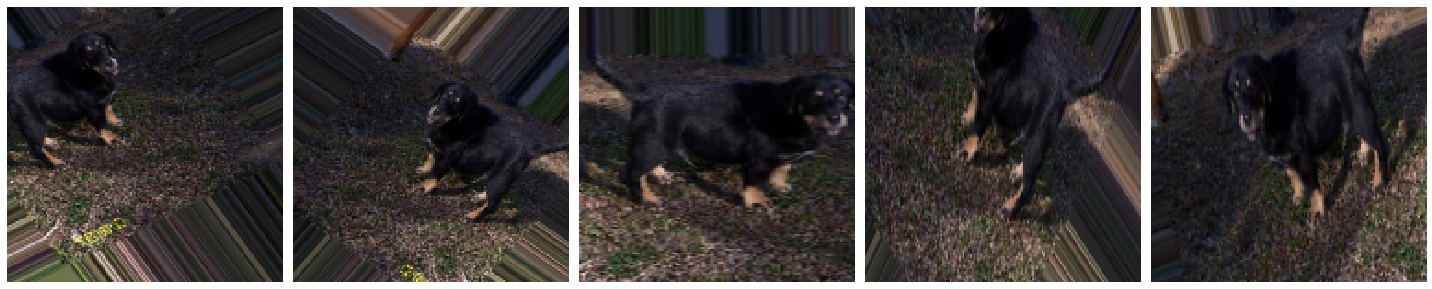

In [34]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### ننشئ مجموعة الصور المستخدمة في تقييم النموذج

بشكل عام نقوم بتطبيق طرق زيادة الصور علي مجموعة الصور التي يتم عليها التدريب  فلذلك لن نقوم بهذه الطرق علي الصور التي يتم عليها تقييم النموذج و سيتم ذلك باستخدام `ImageDataGenerator`.

In [35]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [36]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout

طريقة أخري لتجنب ظاهرة الoverfitting و هو الdropout 
و هي طريقة تجبر الشبكة العصبية علي جعل الأوزان في الشبكة تأخذ قيم صغيرة فقط و هذا يجعل توزيع قيم الأوزان في الشبكة العصبية بشكل منتظم أكثر

عندما نقوم بتطبيق الdropout لطبقة 
يتم ايقاف بعض الوحدات في الشبكة بشكل عشوائي و يكون المخرج لها 0 
هذه الطبقة تأخذ رقم بين 0 و 1 يعبر عن نسبة مئوية لعدد الوحدات التي سيتم توقيفها
علي سبيل المثال إذا كانت القيمة 0.1 فهذا يعني أن 10% من عدد وحدات هذه الطبقة سيتم التوقف عن العمل

سوف نقوم بإنشاء شبكة عصبية تعتمد علي هذا الأسلوب

## Creating a new network with Dropouts

هنا نقوم بتطبيق الdropout لأول و أخر طبقة من الmax pool 
و بهذا سوف يتم ايقاف 20% من الوحدات عشوائيا في كل فترة تكرار للتدريب علي الصور و هذا بدوره يقلل من الoverfitting

In [37]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### نقوم بتدريب النموذج

نبدأ في تدريب النموذج و نستخدم الاعدادات السابق ذكرها

In [38]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### تدريب النموذج

بعدما قدمنا طرق زيادة الصور مع إضافة الdropout للشبكة العصبية نقوم بتدريب النموذج

In [39]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 16s 1s/step - loss: 1.1454 - accuracy: 0.4915 - val_loss: 0.6927 - val_accuracy: 0.5033
Epoch 2/15
15/15 [==============================] - 15s 1s/step - loss: 0.6934 - accuracy: 0.5043 - val_loss: 0.6894 - val_accuracy: 0.5033
Epoch 3/15
15/15 [==============================] - 15s 999ms/step - loss: 0.6926 - accuracy: 0.5021 - val_loss: 0.6898 - val_accuracy: 0.5033
Epoch 4/15
15/15 [==============================] - 15s 1s/step - loss: 0.6880 - accuracy: 0.5064 - val_loss: 0.6784 - val_accuracy: 0.5033
Epoch 5/15
15/15 [==============================] - 15s 1s/step - loss: 0.6744 - accuracy: 0.5411 - val_loss: 0.6795 - val_accuracy: 0.5268
Epoch 6/15
15/15 [==============================] - 15s 1s/step - loss: 0.6678 - accuracy: 0.5556 - val_loss: 0.6507 - val_accuracy: 0.5603
Epoch 7/15
15/15 [==============================] - 15s 993ms/step

### إظهار نتائج النموذج

إيضاح النتائج بعد تدريب النموذج الجديد, نري فارق ملحوظ ب

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

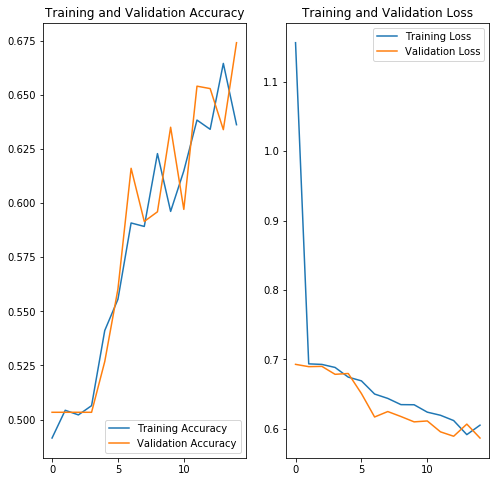

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()